# Exploration des données – Urbanisation de Toulouse

## Contexte et objectif
L’objectif de ce notebook est d’explorer et comprendre le jeu de données utilisé pour prédire la variable cible **`urban_2021`** (binaire), qui indique si une observation appartient à une **zone urbaine** (1) ou **non urbaine** (0) en 2021, sur la zone urbaine de **Toulouse**.

## Description des variables
Le jeu de données combine plusieurs familles de variables explicatives :
- **Indices spectraux** : NDVI, NDBI, NDWI (informations liées à la végétation, au bâti, à l’eau),
- **Variables géographiques** : distances (centre-ville, routes, rails, eau), latitude, longitude,
- **Variables topographiques et socio-démographiques** : pente (slope), densité de population.

## Chemin du fichier
Les données sont chargées depuis :
`data/toulouse_urban_dataset_2021_v2.csv`.

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")


## 1) Chargement des données


In [ ]:
CSV_PATH = "data/toulouse_urban_dataset_2021_v2.csv"
df = pd.read_csv(CSV_PATH)

# Drop colonnes inutiles si présentes
optional_drop = [c for c in ["system:index", ".geo"] if c in df.columns]
if optional_drop:
    df = df.drop(columns=optional_drop)

df.head()


,NDBI,NDVI,NDWI,class_2021,dist_center,dist_rail,dist_road,dist_water,lat,lon,pop_density,slope_deg,urban_2021
0,0.092834,0.120724,-0.184476,50,2211.778215,237.065392,53.851648,671.863081,43.584604,1.444913,338.486847,0.927410,1
1,0.015782,0.123669,-0.208278,50,10770.422494,136.014705,72.111026,1220.163923,43.520126,1.378360,48.522186,3.059466,1
2,-0.011861,0.597159,-0.663193,30,10042.090839,2576.897359,0.000000,730.547740,43.551041,1.544248,58.361877,2.252424,0
3,-0.311915,0.610584,-0.553950,50,9176.318388,44.721360,0.000000,545.893763,43.531827,1.390030,48.583282,0.000000,1
4,0.044857,0.709651,-0.768456,10,11289.141726,1570.350279,50.000000,1073.312629,43.679470,1.349562,0.000000,5.284470,0


Après suppression des colonnes techniques, le jeu de données ne contient que des variables numériques exploitables pour l’apprentissage statistique.

## 2) Structure du dataset


In [31]:
print("Shape:", df.shape)
print("Colonnes:", list(df.columns))
df.info()


Shape: (49903, 13)
Colonnes: ['NDBI', 'NDVI', 'NDWI', 'class_2021', 'dist_center', 'dist_rail', 'dist_road', 'dist_water', 'lat', 'lon', 'pop_density', 'slope_deg', 'urban_2021']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49903 entries, 0 to 49902
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NDBI         49903 non-null  float64
 1   NDVI         49903 non-null  float64
 2   NDWI         49903 non-null  float64
 3   class_2021   49903 non-null  int64  
 4   dist_center  49903 non-null  float64
 5   dist_rail    49903 non-null  float64
 6   dist_road    49903 non-null  float64
 7   dist_water   49903 non-null  float64
 8   lat          49903 non-null  float64
 9   lon          49903 non-null  float64
 10  pop_density  49903 non-null  float64
 11  slope_deg    49903 non-null  float64
 12  urban_2021   49903 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 4.9 MB


### Description des variables

Le jeu de données contient **49 903 observations** et **13 variables**, toutes numériques, décrites ci-dessous :

#### Variable cible
- **`urban_2021`** : variable binaire indiquant si la zone est urbaine (1) ou non urbaine (0) en 2021.

#### Indices spectraux
- **`NDVI`** (*Normalized Difference Vegetation Index*) : indice de végétation, élevé pour les zones végétalisées.
- **`NDBI`** (*Normalized Difference Built-up Index*) : indice de bâti, plus élevé dans les zones urbanisées.
- **`NDWI`** (*Normalized Difference Water Index*) : indice lié à la présence d’eau ou d’humidité.

#### Variables de distance (en mètres)
- **`dist_center`** : distance au centre-ville de Toulouse.
- **`dist_road`** : distance à la route la plus proche.
- **`dist_rail`** : distance à l’infrastructure ferroviaire la plus proche.
- **`dist_water`** : distance au cours d’eau le plus proche.

#### Variables géographiques
- **`lat`** : latitude (système de coordonnées WGS84).
- **`lon`** : longitude (système de coordonnées WGS84).

#### Variables topographiques et socio-démographiques
- **`slope_deg`** : pente du terrain en degrés.
- **`pop_density`** : densité de population locale.

#### Variable de couverture du sol
- **`class_2021`** : classe d’occupation du sol en 2021 (code catégoriel issu du produit ESA WorldCover).

La variable cible **`urban_2021`** est directement dérivée de **`class_2021`** :
les zones dont la classe correspond au bâti (*Built-up*, code 50) sont considérées comme urbaines,
tandis que les autres classes sont regroupées dans la catégorie non urbaine.

In [32]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
NDBI,49903.0,0.009859,0.199564,-0.820339,-0.112493,0.003023,0.116667,0.996190
NDVI,49903.0,0.472881,0.262766,-0.994580,0.285453,0.505671,0.665254,0.999669
NDWI,49903.0,-0.550199,0.251745,-0.999022,-0.717254,-0.600919,-0.411421,0.996661
class_2021,49903.0,34.723363,17.328464,10.000000,10.000000,40.000000,50.000000,90.000000
dist_center,49903.0,7644.507969,2842.189766,11.129269,5634.524616,7953.461343,9756.293931,14072.129019
dist_rail,49903.0,1895.102570,1552.022227,0.000000,610.573501,1523.220273,2852.814400,7555.885124
dist_road,49903.0,40.945008,52.512261,0.000000,10.000000,20.000000,50.990195,473.814310
dist_water,49903.0,528.786876,449.709751,0.000000,183.575598,410.000000,758.946638,2724.646766
lat,49903.0,43.604315,0.051950,43.514583,43.559206,43.604498,43.649200,43.694320
lon,49903.0,1.444869,0.071364,1.320976,1.383080,1.445106,1.506893,1.567642


### Statistiques descriptives

Les statistiques descriptives confirment la cohérence globale du jeu de données :

- Les **indices spectraux** (NDVI, NDBI, NDWI) prennent des valeurs comprises dans l’intervalle théorique \([-1, 1]\), avec :
  - un **NDVI** en moyenne élevé, indiquant une présence importante de végétation,
  - un **NDBI** centré autour de zéro, avec une dispersion marquée entre zones bâties et non bâties,
  - un **NDWI** majoritairement négatif, ce qui est cohérent avec une faible proportion de surfaces en eau.

- Les **variables de distance** sont toutes positives et présentent des distributions asymétriques :
  - la distance au centre-ville varie d’une dizaine de mètres à environ 14 km,
  - les distances aux routes, rails et cours d’eau présentent de nombreux zéros, correspondant à des pixels situés directement sur ces infrastructures.

- La **densité de population** est fortement asymétrique, avec de nombreuses zones peu ou pas peuplées
  et quelques zones très denses, typiquement urbaines.

- La **pente du terrain** est globalement faible (médiane inférieure à 3°),
  ce qui est cohérent avec la topographie de la région toulousaine.

Dans l’ensemble, les distributions suggèrent une séparation potentielle entre zones urbaines et non urbaines, probablement **non linéaire**, ce qui motive l’utilisation de modèles flexibles (arbres de décision, méthodes ensemblistes, réseaux de neurones).


## 3) Variable cible : `urban_2021`


In [33]:
df["urban_2021"].value_counts(normalize=True).rename("proportion")


urban_2021
0    0.59772
1    0.40228
Name: proportion, dtype: float64

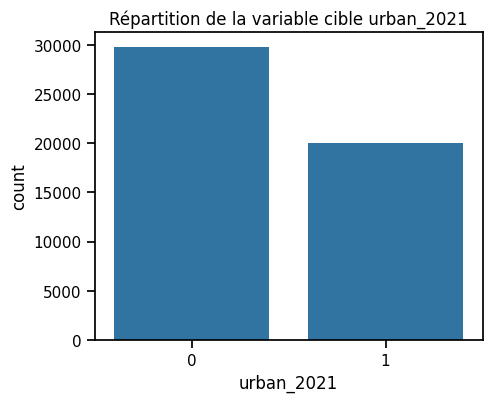

In [34]:
plt.figure(figsize=(5,4))
sns.countplot(x="urban_2021", data=df)
plt.title("Répartition de la variable cible urban_2021")
plt.xlabel("urban_2021")
plt.ylabel("count")
plt.show()


La variable cible `urban_2021` est binaire et présente un déséquilibre modéré, avec environ **40 % d’observations urbaines** et **60 % non urbaines**.

Ce déséquilibre n’est pas extrême mais implique que l’accuracy seule n’est pas une métrique suffisante pour évaluer les performances des modèles. Dans la suite, on privilégiera donc des métriques plus informatives telles que le **ROC-AUC**, le **F1-score** et, le cas échéant, la **balanced accuracy**, afin de mieux évaluer la capacité des modèles à distinguer les deux classes.

## 4) Analyse univariée (distributions)


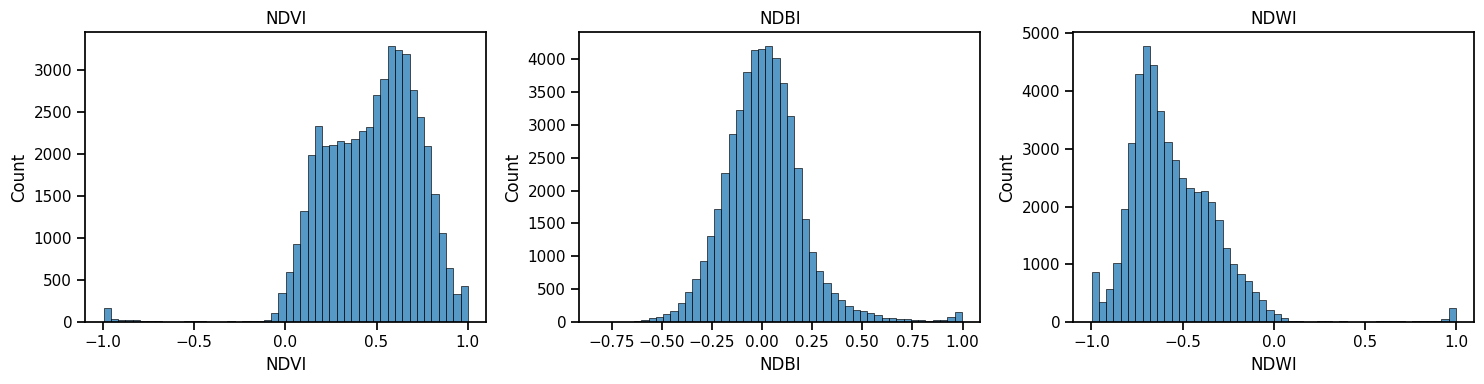

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(df["NDVI"], bins=50, ax=axes[0])
sns.histplot(df["NDBI"], bins=50, ax=axes[1])
sns.histplot(df["NDWI"], bins=50, ax=axes[2])

axes[0].set_title("NDVI")
axes[1].set_title("NDBI")
axes[2].set_title("NDWI")

plt.tight_layout()
plt.show()


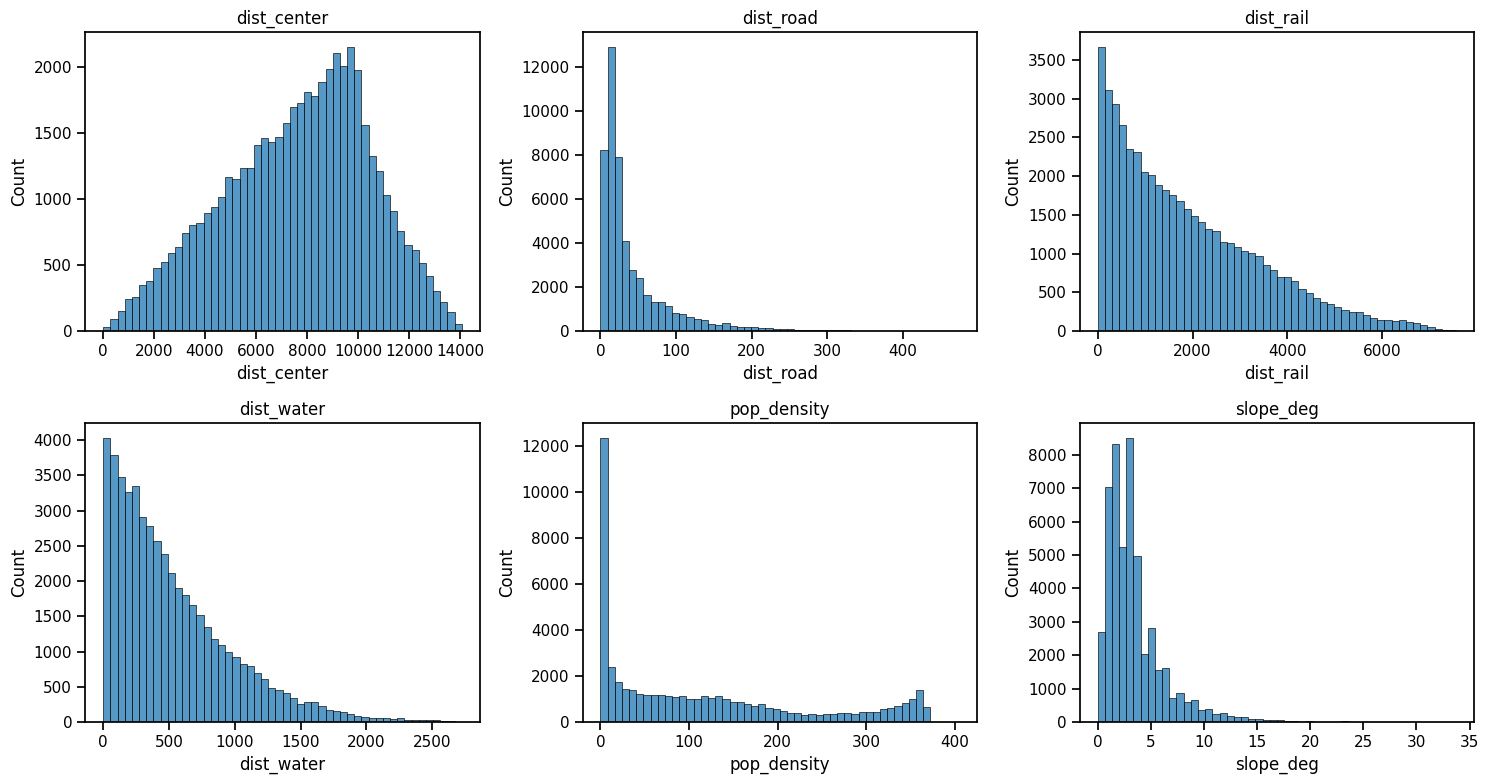

In [36]:
# Distributions de distances / densité
vars_hist = ["dist_center", "dist_road", "dist_rail", "dist_water", "pop_density", "slope_deg"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, var in zip(axes.flatten(), vars_hist):
    sns.histplot(df[var], bins=50, ax=ax)
    ax.set_title(var)
plt.tight_layout()
plt.show()


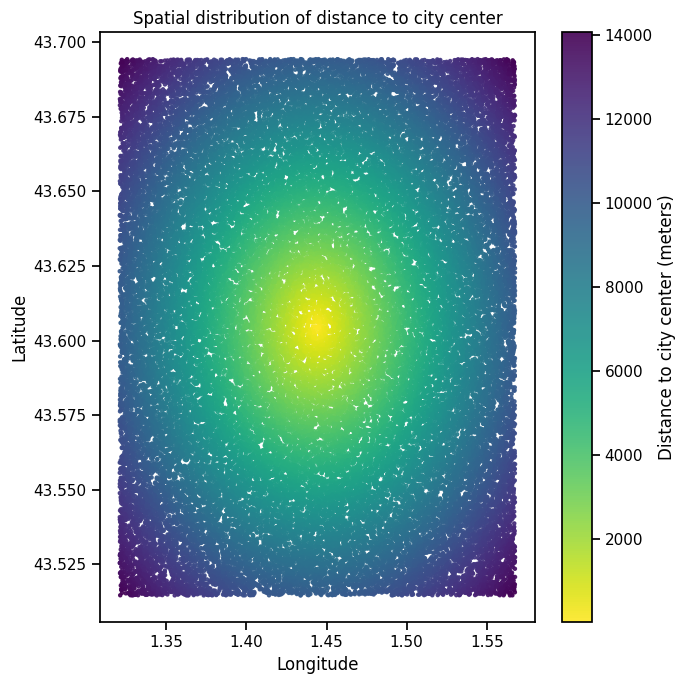

In [37]:
plt.figure(figsize=(7, 7))

sc = plt.scatter(
    df["lon"],
    df["lat"],
    c=df["dist_center"],
    cmap="viridis_r",   # inversé : foncé = proche
    s=5,
    alpha=0.9
)

plt.colorbar(sc, label="Distance to city center (meters)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial distribution of distance to city center")
plt.tight_layout()
plt.show()


**Commentaire**

Les distributions observées sont globalement cohérentes avec la nature des variables :
les indices spectraux (NDVI, NDBI, NDWI) sont bien bornés dans l’intervalle \([-1, 1]\),
les variables de distance sont strictement positives,
et la pente du terrain est majoritairement faible, ce qui est attendu pour la zone étudiée.

De même, la variable de distance au centre-ville apparaît correctement définie, comme le montre la figure précédente.

On observe toutefois des distributions fortement asymétriques pour plusieurs variables,
en particulier les distances aux infrastructures (`dist_road`, `dist_rail`, `dist_water`)
ainsi que la densité de population (`pop_density`), caractérisées par une forte concentration
de valeurs faibles et de longues queues à droite.

Ces asymétries peuvent affecter les performances des modèles sensibles à l’échelle
et à la distribution des variables, tels que la régression logistique ou les réseaux
de neurones. Elles motivent l’utilisation d’une standardisation systématique,
et peuvent justifier l’emploi de transformations de type \(\log(1 + x)\)
pour certaines variables.

## 5) Comparaison par classe (urbain vs non-urbain)


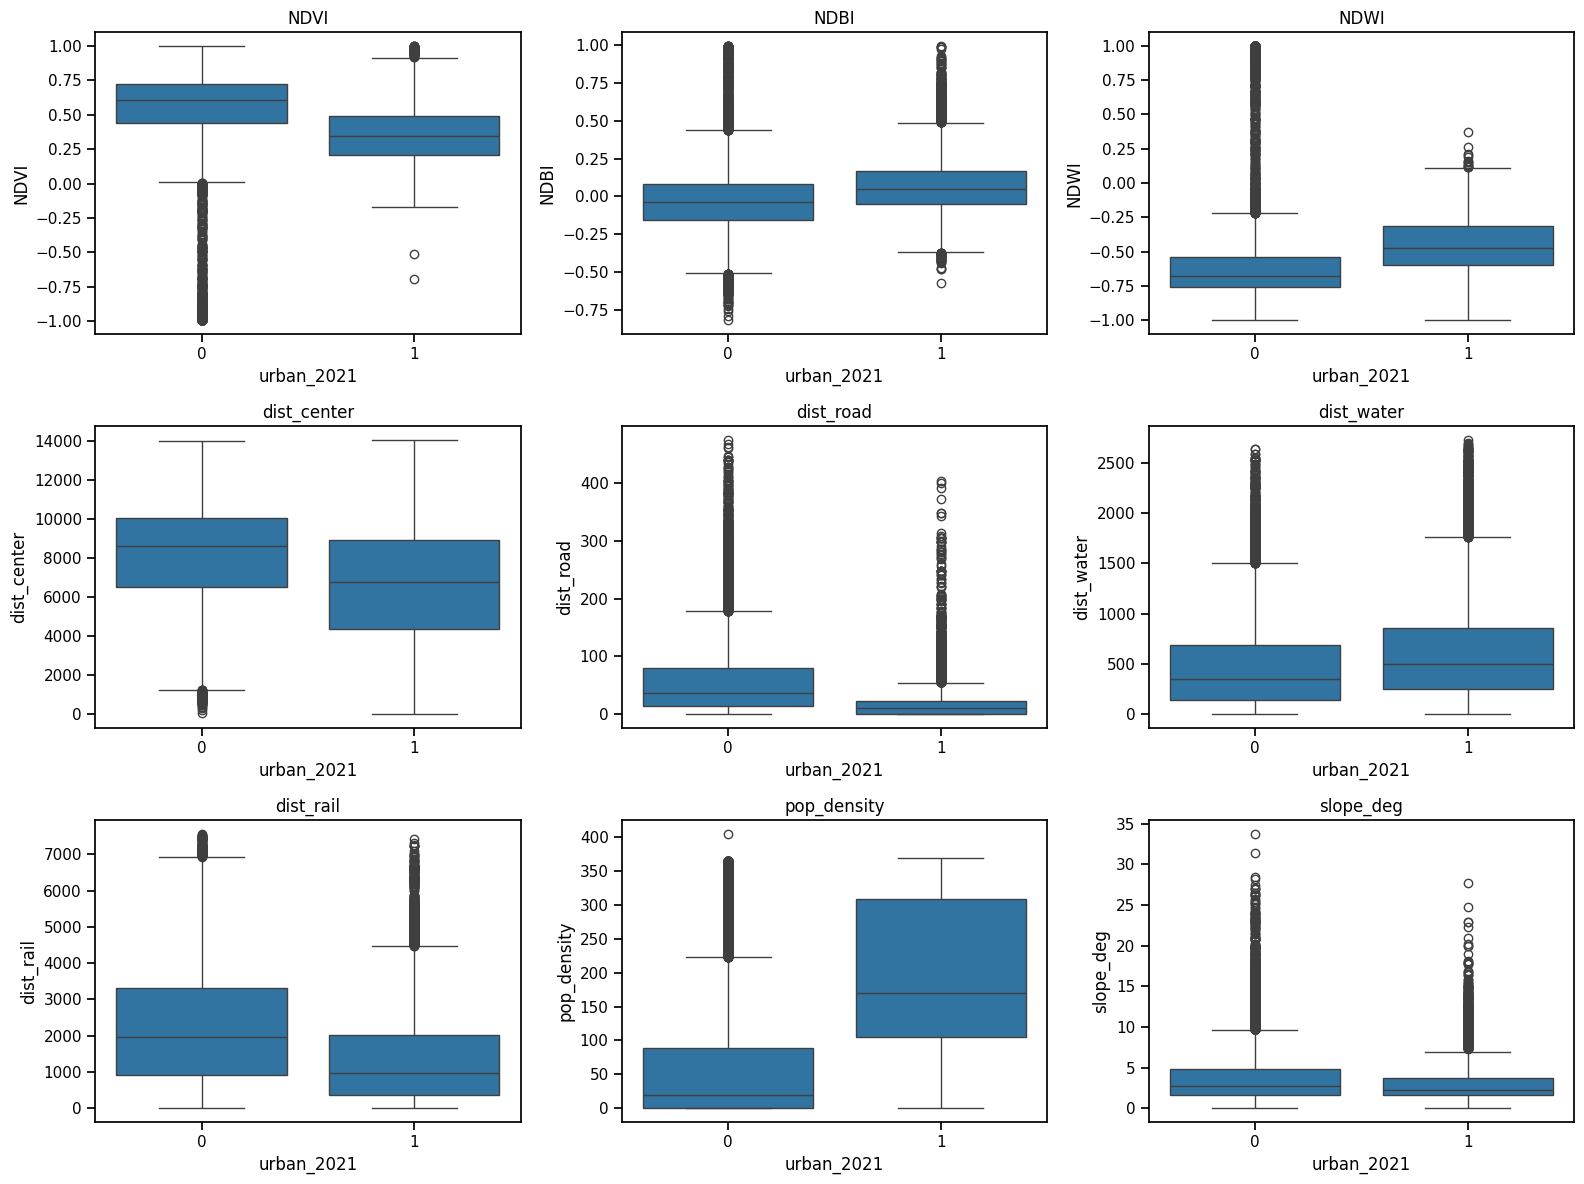

In [38]:
vars_to_plot = ["NDVI", "NDBI", "NDWI", "dist_center", "dist_road", "dist_water", "dist_rail", "pop_density", "slope_deg"]

# Boxplots (attention: beaucoup de points -> boxplot OK, stripplot non)
ncols = 3
nrows = int(np.ceil(len(vars_to_plot)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    sns.boxplot(x="urban_2021", y=var, data=df, ax=axes[i])
    axes[i].set_title(var)

# remove empty axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [39]:
# Moyennes conditionnelles (résumé numérique rapide)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
group_means = df.groupby("urban_2021")[num_cols].mean(numeric_only=True)

display_cols = ["NDBI","NDVI","NDWI","dist_center","dist_road","pop_density","slope_deg"]
group_means[display_cols]


,NDBI,NDVI,NDWI,dist_center,dist_road,pop_density,slope_deg
urban_2021,,,,,,,
0,-0.030280,0.554081,-0.615899,8287.029471,56.635406,62.536450,3.836637
1,0.069499,0.352233,-0.452579,6689.831438,17.631772,193.121312,2.830350


**Commentaire**

On s’attend (et on observe effectivement sur les figures) à des différences marquées
entre zones urbaines et non urbaines :

- les zones urbaines présentent en moyenne un **NDBI plus élevé** et un **NDVI plus faible**,
  traduisant une plus forte présence de surfaces artificialisées et une moindre couverture végétale ;
- la **densité de population** est nettement plus élevée dans les zones urbaines,
  avec une distribution bien séparée de celle des zones non urbaines ;
- les zones urbaines sont en moyenne **plus proches du centre-ville** et **des infrastructures routières et ferroviaires**,
  comme le montrent les distributions décalées de `dist_center`, `dist_road` et `dist_rail`.

On observe néanmoins un **chevauchement non négligeable des distributions** pour plusieurs variables,
notamment les indices spectraux et certaines distances, ce qui reflète la présence
de zones de transition (périurbain, urbanisation diffuse).

Ces observations suggèrent une **bonne séparabilité globale**, mais avec des frontières
complexes et non linéaires entre les classes, ce qui motive l’utilisation de modèles
capables de capturer des interactions et des relations non linéaires
(arbres de décision, Random Forest, Gradient Boosting, réseaux de neurones).


## 6) Sanity check spatial (lat/lon)


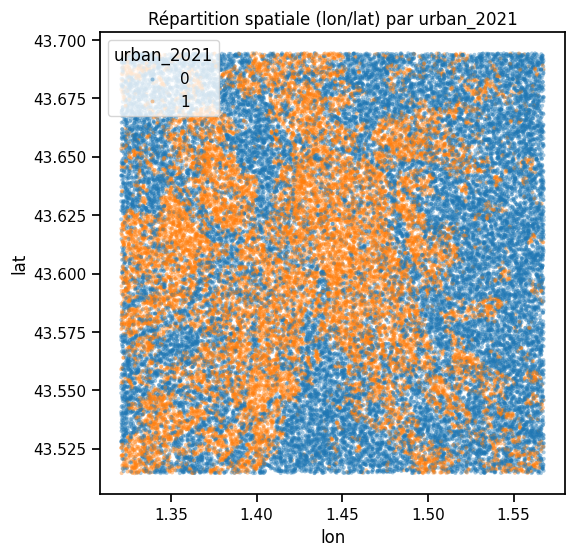

In [40]:
# Scatter spatial (attention: 50k points -> alpha faible)
plt.figure(figsize=(6, 6))
sns.scatterplot(x="lon", y="lat", hue="urban_2021", data=df, s=8, alpha=0.4, linewidth=0)
plt.title("Répartition spatiale (lon/lat) par urban_2021")
plt.xlabel("lon")
plt.ylabel("lat")
plt.legend(title="urban_2021", loc="best")
plt.show()


La structure spatiale est cohérente avec la ville de Toulouse.  

## 7) Corrélations entre variables


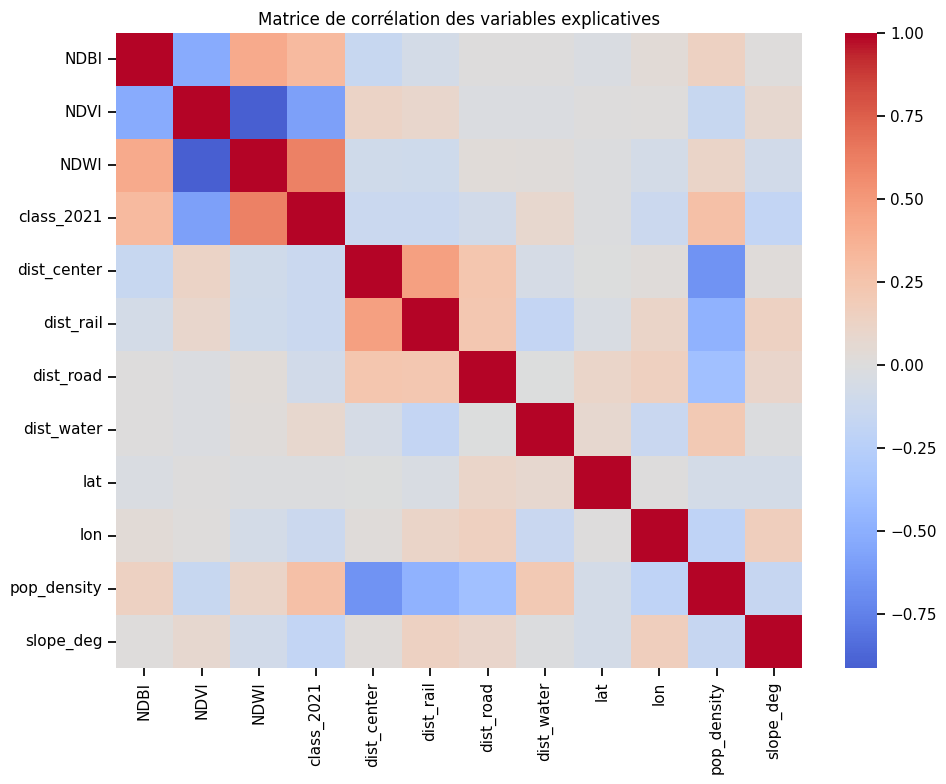

In [41]:
# Corrélations (variables explicatives uniquement)
X = df.drop(columns=["urban_2021"])
corr = X.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, center=0, cmap="coolwarm")
plt.title("Matrice de corrélation des variables explicatives")
plt.tight_layout()
plt.show()


La matrice de corrélation met en évidence plusieurs relations attendues entre
les variables explicatives.

Les **indices spectraux** présentent des corrélations marquées :
le NDVI est fortement anticorrélé au NDWI, et modérément anticorrélé au NDBI,
ce qui reflète l’opposition entre surfaces végétalisées, humides et bâties.
Ces relations traduisent une redondance partielle de l’information spectrale.

Les **variables de distance** sont également corrélées entre elles,
en particulier les distances au centre-ville, aux routes et aux voies ferrées,
ce qui est cohérent avec l’organisation spatiale des infrastructures urbaines.

Les variables géographiques (`lat`, `lon`) et topographiques (`slope_deg`)
présentent des corrélations faibles avec la majorité des autres variables,
indiquant qu’elles apportent une information complémentaire.

D’un point de vue méthodologique, ces corrélations peuvent affecter
les modèles linéaires en introduisant de la multicolinéarité ;
l’utilisation de techniques de régularisation permet d’en atténuer les effets.
À l’inverse, les modèles ensemblistes sont peu sensibles à ces corrélations,
ce qui contribue à leurs bonnes performances observées.

## 8) Conclusion de l’exploration

- Le dataset est **propre** (pas de NA) et les plages de valeurs sont plausibles.
- La cible `urban_2021` est binaire et **modérément déséquilibrée**.
- Les variables (NDBI, NDVI, distances, densité) montrent des différences nettes entre classes → bon potentiel prédictif.